In [1]:
# import libraries
# public data
import yfinance as yf
# data manipulation
import pandas as pd
import numpy as np
# visualization
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
# pre-processing
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
# svm
from sklearn.svm import SVR
# metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# load data
df = yf.download('SPY', start='2000-01-01',progress=False)
df = df[['Adj Close']]
df.tail()

,Adj Close
Date,
2022-05-27,415.260010
2022-05-31,412.929993
2022-06-01,409.589996
2022-06-02,417.390015
2022-06-03,410.540009


In [3]:
# n day to predict
n = 5
# target
df['Target'] = df['Adj Close'].shift(-n)
df.tail(7)

,Adj Close,Target
Date,,
2022-05-25,397.369995,417.390015
2022-05-26,405.309998,410.540009
2022-05-27,415.260010,NaN
2022-05-31,412.929993,NaN
2022-06-01,409.589996,NaN
2022-06-02,417.390015,NaN
2022-06-03,410.540009,NaN


In [4]:
# predicators
X = df[['Adj Close']].values[:-n]
X

array([[ 97.50943756],
       [ 96.55508423],
       [ 92.77918243],
       ...,
       [393.89001465],
       [397.36999512],
       [405.30999756]])

In [5]:
# labels
y = df['Target'].values[:-n]
y

array([ 96.76252747,  97.09451294,  95.93265533, ..., 409.58999634,
       417.39001465, 410.54000854])

In [6]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
print(f"train and test size {len(X_train)},{len(X_test)}")

train and test size 4510,1128


In [7]:
# fit model
pipe = Pipeline([("scaler", MinMaxScaler()), ("regressor", SVR(kernel='rbf', C=1e3, gamma=0.1))])
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('regressor', SVR(C=1000.0, gamma=0.1))])

In [8]:
# predict test
y_pred = pipe.predict(X_test)
y_pred[-5:] # last five predictions

array([364.64831241, 369.54652682, 367.52641993, 369.84460522,
       375.02161666])

In [9]:
# metrics (r2_score)
pipe.score(X_test, y_test)

0.885911562197724

In [10]:
print(f'train accuracy: {pipe.score(X_train, y_train): 0.4}')
print(f'test accuracy: {pipe.score(X_test, y_test): 0.4}')

train accuracy:  0.9971
test accuracy:  0.8859


In [11]:
# hyperparamter tunnng
# cross validation
tscv = TimeSeriesSplit(n_splits=5)

In [12]:
pipe.get_params()

{'memory': None,
 'steps': [('scaler', MinMaxScaler()),
  ('regressor', SVR(C=1000.0, gamma=0.1))],
 'verbose': False,
 'scaler': MinMaxScaler(),
 'regressor': SVR(C=1000.0, gamma=0.1),
 'scaler__clip': False,
 'scaler__copy': True,
 'scaler__feature_range': (0, 1),
 'regressor__C': 1000.0,
 'regressor__cache_size': 200,
 'regressor__coef0': 0.0,
 'regressor__degree': 3,
 'regressor__epsilon': 0.1,
 'regressor__gamma': 0.1,
 'regressor__kernel': 'rbf',
 'regressor__max_iter': -1,
 'regressor__shrinking': True,
 'regressor__tol': 0.001,
 'regressor__verbose': False}

In [13]:
# gridsearch and fit
param_grid = {"regressor__C": [0.1, 1, 10, 100, 1000],
              "regressor__kernel": ['poly', 'rbf', 'sigmoid'],
              "regressor__gamma": [1e-7, 1e-4, 1e-3, 1e-2]}

gs = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=tscv, verbose=1)
gs.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('regressor',
                                        SVR(C=1000.0, gamma=0.1))]),
             n_jobs=-1,
             param_grid={'regressor__C': [0.1, 1, 10, 100, 1000],
                         'regressor__gamma': [1e-07, 0.0001, 0.001, 0.01],
                         'regressor__kernel': ['poly', 'rbf', 'sigmoid']},
             verbose=1)

In [14]:
# best estimator
gs.best_estimator_

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('regressor', SVR(C=1000, gamma=0.01, kernel='sigmoid'))])

In [15]:
# best params
params = gs.best_params_
params

{'regressor__C': 1000,
 'regressor__gamma': 0.01,
 'regressor__kernel': 'sigmoid'}

In [16]:
# best score
gs.best_score_

0.9719388052330512

In [17]:
# predict test
y_preds = gs.predict(X_test)
y_preds[-5:]

array([390.66355618, 397.97164781, 394.93413934, 398.42274399,
       406.38237853])

In [18]:
# metrics
print(f"train accuracy\t: {gs.score(X_train, y_train): 0.6}")
print(f"test accuracy\t: {gs.score(X_test, y_test): 0.6}")

train accuracy	:  0.997137
test accuracy	:  0.986774


In [19]:
# visualization
df3 = pd.DataFrame({"X": X_test.flatten(), "y": y_preds})
df3['X'] = df3['X'].shift(-n)
df3['X-y'] = df3['X'] - df3['y']
df3=df3[:-n]
df3.tail(n)

,X,y,X-y
1118,389.630005,402.783514,-13.153509
1119,396.920013,401.149478,-4.229464
1120,393.890015,409.399814,-15.509799
1121,397.369995,392.899074,4.470921
1122,405.309998,390.493120,14.816877


In [20]:
# check missing values
df3.isnull().sum()

X      0
y      0
X-y    0
dtype: int64

In [21]:
# mean difference
print(f'mean Difference\t: {np.mean(df3["X-y"]):0.4}')

mean Difference	: -0.1946


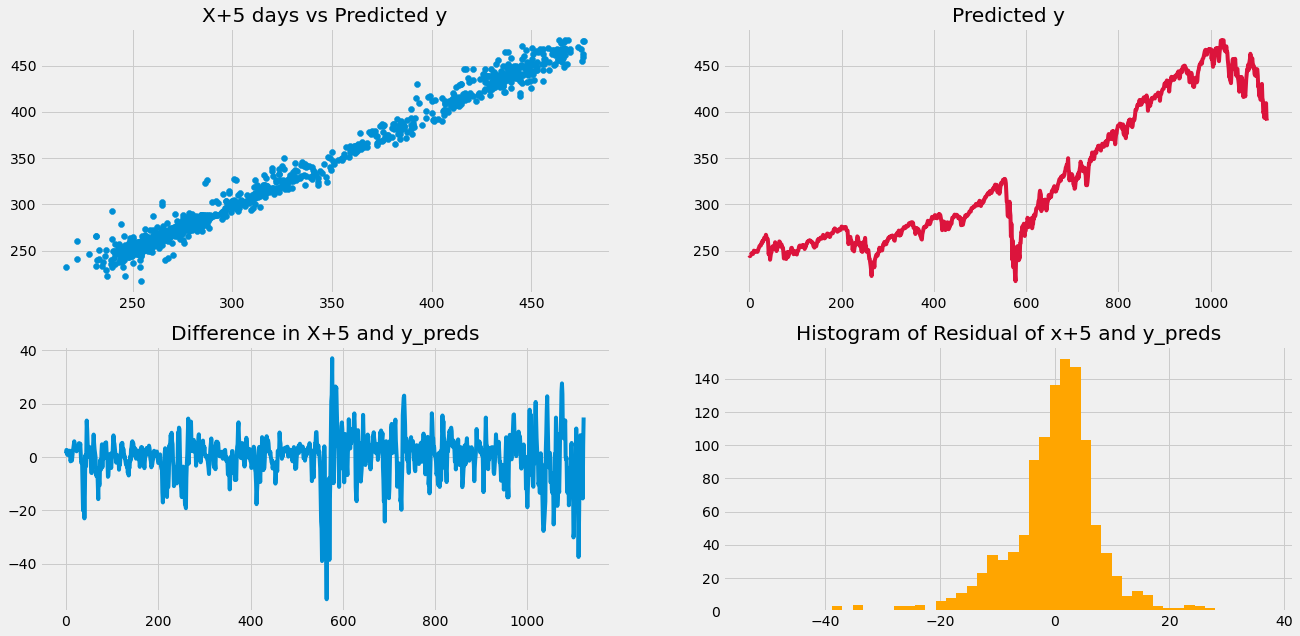

In [22]:
# plot x+5 vs y_pred
fig, ax = plt.subplots(2,2, figsize=(20,10))

ax[0,0].scatter(df3['X'], df3['y'])
ax[0,0].set_title('X+5 days vs Predicted y')

# plot Predicted Price
ax[0,1].plot(df3.index, y_preds[:-n], 'crimson')
ax[0,1].set_title('Predicted y')

# plot Residual of x+5 and y_pred 
ax[1,0].plot(df3.index, df3['X-y'])
ax[1,0].set_title('Difference in X+5 and y_preds')

# plot Histogram of Residual of x+5 and y_pred 
ax[1,1].hist(df3['X-y'], bins=50, density=False, color='orange')
ax[1,1].set_title('Histogram of Residual of x+5 and y_preds');